In [3]:
import sys
#sys.path
sys.path.append('../')

In [217]:
%load_ext autoreload
%autoreload 2
import sklearn
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from bokeh.plotting import figure, show, output_notebook, output_file, save
from functions import merge_data
from sklearn.model_selection import RandomizedSearchCV
import load_data
import exponential_modeling
import fit_and_predict
import copy

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## get prediction for next day

There are currently two models:   
  1. method="exponential" fits an exponential curve to the number of deaths  
  2. method="cases_exponential_rate_constant" fits an exponential curve to the number of cases, and use the death rate of the previous day to estimate deaths  

In [286]:
df = load_data.load_county_level(data_dir = '../data/')
outcome_deaths = '#Deaths_3/26/2020'
df = df.sort_values(outcome_deaths, ascending=False)
#outcome_cases = load_data.outcome_cases # most recent day
#outcome_deaths = load_data.outcome_deaths
important_vars = load_data.important_keys(df)

In [278]:
df.keys()

Index(['id', 'Header-FIPSStandCtyCode', 'EntityofFile',
       'SecondaryEntityOfFile', 'DateofFile', 'DateofCreation', 'FileLength',
       'StateName', 'StateNameAbbreviation', 'CountyName',
       ...
       '#Deaths_3/22/2020', '#Deaths_3/23/2020', '#Deaths_3/24/2020',
       '#Deaths_3/25/2020', '#Deaths_3/26/2020', '#Deaths_3/27/2020', 'deaths',
       'cases', 'tot_deaths', 'tot_cases'],
      dtype='object', length=7318)

In [283]:
df = exponential_modeling.estimate_deaths(df, mode='predict_future')

In [287]:
df['deaths'].values[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,  21,  40,  60,  92, 124,
       149])

In [284]:
df['predicted_deaths_exponential']

1841    [231.98702647965587]
2941    [141.89562378110494]
1824    [155.85977461115073]
1803     [151.5894789479785]
1831      [124.153507351064]
                ...         
1107                     [0]
1108                     [0]
1110                     [0]
1112                     [0]
3113                     [0]
Name: predicted_deaths_exponential, Length: 3114, dtype: object

## Validation (for counties with more than 5 deaths)

In [221]:
df2 = exponential_modeling.create_leave_one_day_out_valid(df)
method = 'cases_exponential_rate_constant'
df2 = exponential_modeling.estimate_deaths(df2, method=method)

In [222]:
outcome = np.array([df['deaths'].values[i][-1] for i in range(len(df))])
preds = np.array([df2['predicted_deaths_exponential'].values[i][0] for i in range(len(df))])

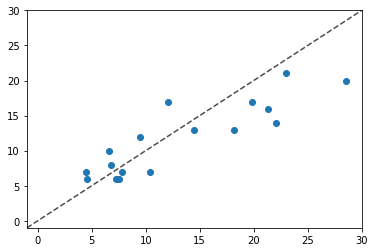

In [223]:
plt.scatter((preds[outcome > 5]), (outcome[outcome > 5]))
axis_lim = [-1, 30]
plt.xlim(axis_lim)
plt.ylim(axis_lim)
plt.plot(axis_lim, axis_lim, ls="--", c=".3")

## Different time horizon

In [224]:
h = 3 # predicting 3 days in advance
previous_deaths = [d[:-h] for d in copy.deepcopy(df['deaths'])]
previous_cases = [c[:-h] for c in copy.deepcopy(df['cases'])]
train_df = copy.deepcopy(df)
train_df['deaths'] = previous_deaths
train_df['cases'] = previous_cases
#test_df = copy.deepcopy(df)
#df_preds = fit_and_predict.fit_and_predict(train_df, test_df, method='exponential', target_day=[h])

### fitting exponential curve to number of deaths

In [225]:
#df_preds = fit_and_predict.fit_and_predict(train_df, test_df, method='exponential', target_day=[h])
df_preds = exponential_modeling.estimate_deaths(train_df,
                                                method='exponential',
                                                target_day=np.array([h]))
preds = [df_preds['predicted_deaths_exponential'].values[i][0] for i in range(len(df))]

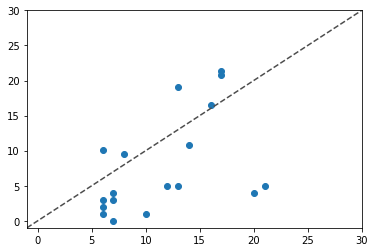

In [226]:
plt.scatter((outcome[outcome > 5]), np.array(preds)[outcome > 5])
axis_lim = [-1, 30]
plt.xlim(axis_lim)
plt.ylim(axis_lim)
plt.plot(axis_lim, axis_lim, ls="--", c=".3")

## underestimaing most of the time

### fitting exponential curve to number of cases, then multiply by death rate

In [227]:
method = 'cases_exponential_rate_constant'
df_preds = exponential_modeling.estimate_deaths(train_df,
                                                method=method,
                                                target_day=np.array([h]))
preds = [df_preds['predicted_deaths_exponential'].values[i][0] for i in range(len(df))]
outcome = np.array([df['deaths'].values[i][-1] for i in range(len(df))])

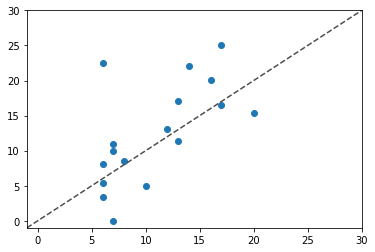

In [230]:
plt.scatter((outcome[outcome > 5]), np.array(preds)[outcome > 5])
axis_lim = [-1, 30]
plt.xlim(axis_lim)
plt.ylim(axis_lim)
plt.plot(axis_lim, axis_lim, ls="--", c=".3")

## overestimaing most of the time

In [288]:
df = fit_and_predict.get_forecasts(df,
                                   outcome='deaths',
                                   method='exponential',
                                   output_key='predicted_deaths_exponential')

In [289]:
df['predicted_deaths_exponential']

1841    [231.98702647965587]
2941    [141.89562378110494]
1824    [155.85977461115073]
1803     [151.5894789479785]
1831      [124.153507351064]
                ...         
1089                     [0]
1090                     [0]
1091                     [0]
1093                     [0]
3113                     [0]
Name: predicted_deaths_exponential, Length: 3114, dtype: object

In [291]:
df = fit_and_predict.get_forecasts(df,
                                  outcome='deaths',
                                  method='shared_exponential',
                                  output_key='predicted_deaths_shared_exponential')

In [301]:
[df['predicted_deaths_shared_exponential'].values[i][0] for i in range(len(df))]

[183.66281137176944,
 121.15066520087018,
 128.22577560917534,
 126.1731924583264,
 92.56914875895471,
 56.72340917651218,
 35.82380949260184,
 35.49547297243975,
 34.20017808994436,
 33.915134945299194,
 30.295450365824994,
 25.05066513288835,
 19.613482597845536,
 22.922028972863686,
 26.191624852412353,
 28.522294503742526,
 19.315669728195928,
 24.695118729645813,
 14.150821278143487,
 18.24363550781083,
 11.750665291382742,
 12.035694443819567,
 10.34483851782638,
 9.302828448800643,
 8.485577897058697,
 8.632884844357658,
 6.593108780851284,
 9.534876940801393,
 9.352230539916343,
 13.478444974358398,
 7.7944602235612725,
 7.1823195419782175,
 8.129188183735753,
 9.838496216256374,
 7.710960680783581,
 10.117037857897065,
 7.3333379941782155,
 5.873729622737052,
 7.036352032960879,
 7.504423465875302,
 11.976822732061926,
 6.10488621484709,
 7.154382871033154,
 10.624512603238093,
 5.501859623354556,
 6.966572690824897,
 5.178434693625476,
 6.637412298338987,
 5.850092565619692,


In [ ]:
### weighted estimators

In [302]:
import pmdl_weight
weights = pmdl_weight.compute_pmdl_weight(df, methods=['shared_exponential', 'exponential'], outcome='deaths')

In [305]:
weights['exponential'][:20]

array([7.24353195e-11, 2.12213924e-06, 7.23551909e-12, 5.47678197e-14,
       7.70503754e-10, 5.30437892e-02, 4.75048392e-02, 7.43205330e-04,
       3.07095976e-02, 5.13139513e-02, 4.19464783e-02, 4.81135213e-02,
       4.31871028e-02, 9.52193547e-02, 1.67834725e-01, 1.14920117e-01,
       2.37880822e-01, 4.89238067e-02, 1.65827832e-01, 6.40143831e-02])

In [306]:
weights['shared_exponential'][:20]

array([3.19371114e-09, 5.28037080e-07, 1.73327588e-07, 2.87738922e-09,
       6.50862040e-11, 2.24014384e-03, 1.23853499e-03, 9.12932404e-04,
       2.98471854e-02, 5.10919528e-02, 5.84752408e-02, 6.04218184e-02,
       3.96575726e-03, 5.43044861e-02, 9.42122826e-02, 2.53236004e-02,
       1.90427374e-01, 2.10005929e-02, 1.75759236e-01, 3.72785398e-01])